In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.kuka.reaching import KukaReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [5]:
savepath = parentdir + '/data/kuka/'

In [6]:
# data_train = np.load(savepath+'data_pd_reg.npy')
# task = KukaReaching(render=True)
# task.visualize_training_data(data_train, 0)

In [7]:
task = KukaReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub
v_lb, v_ub = -100 * torch.ones_like(q_lb), 100 * torch.ones_like(q_ub)

In [8]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.pd import PD

na = 14
gain_ub = torch.Tensor([30, 15, 30, 30, 5, 3, 0.1])
gain_lb = 0. * torch.ones((nq))
action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))
actor = Actor(PD(nx, nq, nv, nu), action_lb, action_ub)

task.cost.actor = actor

In [9]:
# Setup model learning

from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5 
batch_size = 64
epochs = 10
dynamics = ProbabilisticEnsemble(nx, nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size, 
                                 learning_rate=0.001)

dynamics.state_lb = torch.cat((q_lb, v_lb))
dynamics.state_ub = torch.cat((q_ub, v_ub))

In [10]:
# Setup controller

from stage.controllers.pets import PETS

plan_horizon = 30
n_particles = 20
pop_size = 500
assert n_particles % ensemble_size == 0

controller = PETS(dynamics, task.cost, actor,
                  plan_horizon, n_particles, pop_size)

In [11]:
# Setup learner
from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller, epochs, batch_size)

In [12]:
q_start = torch.Tensor(task.q_start).unsqueeze(0)
q_desired = task.cost.desired[:nq].unsqueeze(0)

print (task.cost.fwk(q_start, 6)[:, :3, 3])
print (task.cost.fwk(q_desired, 6)[:, :3, 3])

tensor([[ 0.4006, -0.5008, -0.0008]])
tensor([[0.3931, 0.4873, 0.0099]])


In [13]:
lip_reg = False

if lip_reg:
    controller.regularize(1)
    file_name = savepath + 'data_pd_reg'
else: 
    controller.regularize(0)
    file_name = savepath + 'data_pd_noreg'
    
_ = learner.learn(50, verbose=True)
learner.save_training_data(file_name)

Network training: 100%|██████████| 10/10 [00:00<00:00, 28.24epoch(s)/s, Training loss MSE=0.51114154]


Iteration:  0
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.022229231198628744
obs. reward:  -181.77191
act. reward:  -0.1434254


Network training: 100%|██████████| 10/10 [00:00<00:00, 17.55epoch(s)/s, Training loss MSE=0.23057492]


Iteration:  1
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8284426641464233
obs. reward:  -160.72969
act. reward:  -0.019904384


Network training: 100%|██████████| 10/10 [00:00<00:00, 15.69epoch(s)/s, Training loss MSE=0.14244501]


Iteration:  2
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8224126927057902
obs. reward:  -152.60977
act. reward:  -0.018647227


Network training: 100%|██████████| 10/10 [00:01<00:00,  9.59epoch(s)/s, Training loss MSE=6.2450023]


Iteration:  3
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8200383281707764
obs. reward:  -167.1413
act. reward:  -3.7134311


Network training: 100%|██████████| 10/10 [00:00<00:00, 10.62epoch(s)/s, Training loss MSE=4.5369534]


Iteration:  4
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8376823584238688
obs. reward:  -111.0223
act. reward:  -0.011067368


Network training: 100%|██████████| 10/10 [00:01<00:00,  8.28epoch(s)/s, Training loss MSE=3.5373373]


Iteration:  5
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8416191260019938
obs. reward:  -156.95583
act. reward:  -0.02619524


Network training: 100%|██████████| 10/10 [00:01<00:00,  7.62epoch(s)/s, Training loss MSE=2.6710453]


Iteration:  6
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.821108365058899
obs. reward:  -83.10312
act. reward:  -0.03031253


Network training: 100%|██████████| 10/10 [00:01<00:00,  6.64epoch(s)/s, Training loss MSE=2.1111145]


Iteration:  7
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8202528619766235
obs. reward:  -87.4678
act. reward:  -0.11369282


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.82epoch(s)/s, Training loss MSE=1.6308869]


Iteration:  8
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8206944100062052
obs. reward:  -139.91492
act. reward:  -0.028872557


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.22epoch(s)/s, Training loss MSE=1.2757989]


Iteration:  9
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8203487777709961
obs. reward:  -109.615715
act. reward:  -0.059917077


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.77epoch(s)/s, Training loss MSE=1.0343509]


Iteration:  10
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8218205372492472
obs. reward:  -63.432808
act. reward:  -0.09708221


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.37epoch(s)/s, Training loss MSE=1.0547646]


Iteration:  11
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8202023553848267
obs. reward:  -75.36647
act. reward:  -0.053777024


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.70epoch(s)/s, Training loss MSE=2.0533507]


Iteration:  12
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8212772353490194
obs. reward:  -125.10584
act. reward:  -0.2449932


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.51epoch(s)/s, Training loss MSE=1.6124961]


Iteration:  13
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.819661808013916
obs. reward:  -124.681755
act. reward:  -0.08523935


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.57epoch(s)/s, Training loss MSE=1.345995]


Iteration:  14
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8213972600301107
obs. reward:  -107.2727
act. reward:  -0.23435695


Network training: 100%|██████████| 10/10 [00:03<00:00,  3.07epoch(s)/s, Training loss MSE=1.5745294]


Iteration:  15
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8208436791102092
obs. reward:  -175.34958
act. reward:  -0.40793633


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.96epoch(s)/s, Training loss MSE=1.7841519]


Iteration:  16
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8204531145095825
obs. reward:  -169.19174
act. reward:  -0.35918215


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.78epoch(s)/s, Training loss MSE=1.6594919]


Iteration:  17
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8201716788609823
obs. reward:  -139.66336
act. reward:  -0.1422003


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.93epoch(s)/s, Training loss MSE=1.7298838]


Iteration:  18
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8184786669413249
obs. reward:  -145.01387
act. reward:  -0.16421646


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.37epoch(s)/s, Training loss MSE=2.2185903]


Iteration:  19
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8215623664855957
obs. reward:  -115.057816
act. reward:  -0.24800926


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.18epoch(s)/s, Training loss MSE=2.32969] 


Iteration:  20
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8220095952351888
obs. reward:  -168.20699
act. reward:  -0.46056655


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.08epoch(s)/s, Training loss MSE=2.185462]


Iteration:  21
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8220351505279541
obs. reward:  -155.68349
act. reward:  -0.18521404


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.32epoch(s)/s, Training loss MSE=2.0758567]


Iteration:  22
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.821751618385315
obs. reward:  -145.67966
act. reward:  -0.13383412


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.14epoch(s)/s, Training loss MSE=1.9915016]


Iteration:  23
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8216081730524699
obs. reward:  -86.63938
act. reward:  -0.19130562


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.91epoch(s)/s, Training loss MSE=1.8797207]


Iteration:  24
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8203052552541097
obs. reward:  -71.01087
act. reward:  -0.2442984


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.02epoch(s)/s, Training loss MSE=1.8600272]


Iteration:  25
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.821362460454305
obs. reward:  -119.565575
act. reward:  -0.28629142


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.77epoch(s)/s, Training loss MSE=1.8488501]


Iteration:  26
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.821977079709371
obs. reward:  -42.205956
act. reward:  -0.22532621


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.58epoch(s)/s, Training loss MSE=2.0937448]


Iteration:  27
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8219631719589233
obs. reward:  -57.891212
act. reward:  -0.15473944


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.76epoch(s)/s, Training loss MSE=1.8650391]


Iteration:  28
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8229326407114664
obs. reward:  -102.050735
act. reward:  -0.030711588


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.77epoch(s)/s, Training loss MSE=1.8015454]

Iteration:  29
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8208371082941691
obs. reward:  -180.91792
act. reward:  -0.19340628


In [28]:
controller.regularize(0)
_ = learner.learn(1, verbose=True)

Network training: 100%|██████████| 10/10 [00:06<00:00,  1.50epoch(s)/s, Training loss MSE=2.9480522]

Iteration:  0
Initial state:  tensor([-0.7528,  1.4370, -0.2040, -1.1921, -0.0062,  0.2165,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
avg. decision time:  0.8230135822296143
obs. reward:  -34.7302
act. reward:  -0.24584657


In [29]:
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  0.8210671377182007
obs. reward:  -25.92201
act. reward:  -0.16930267


In [30]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(15.4677, grad_fn=<MeanBackward0>)
tensor(21.8611, grad_fn=<StdBackward0>)


In [31]:
task_horizon = task.task_horizon
ee_pred = torch.zeros(task_horizon, n_sample, 3)
ee = torch.zeros(task_horizon, 3)

for n in range(task_horizon):
    ee_pred[n] = task.cost.fwk(traj_pred[n,:,:nq], 6)[:, :3, 3]
    ee[n] = task.cost.fwk(traj[n:n+1,:nq], 6)[:, :3, 3]

In [32]:
ee_pred_mean = torch.mean(ee_pred, dim=1)
ee_pred_std = torch.std(ee_pred, dim=1)

ee_pred_mean_np = ee_pred_mean.detach().cpu().numpy()
ee_pred_std_np = ee_pred_std.detach().cpu().numpy()
ee_np = ee.detach().cpu().numpy()

goal = task.cost.goal.repeat(task_horizon, 1)
goal = goal.detach().cpu().numpy()

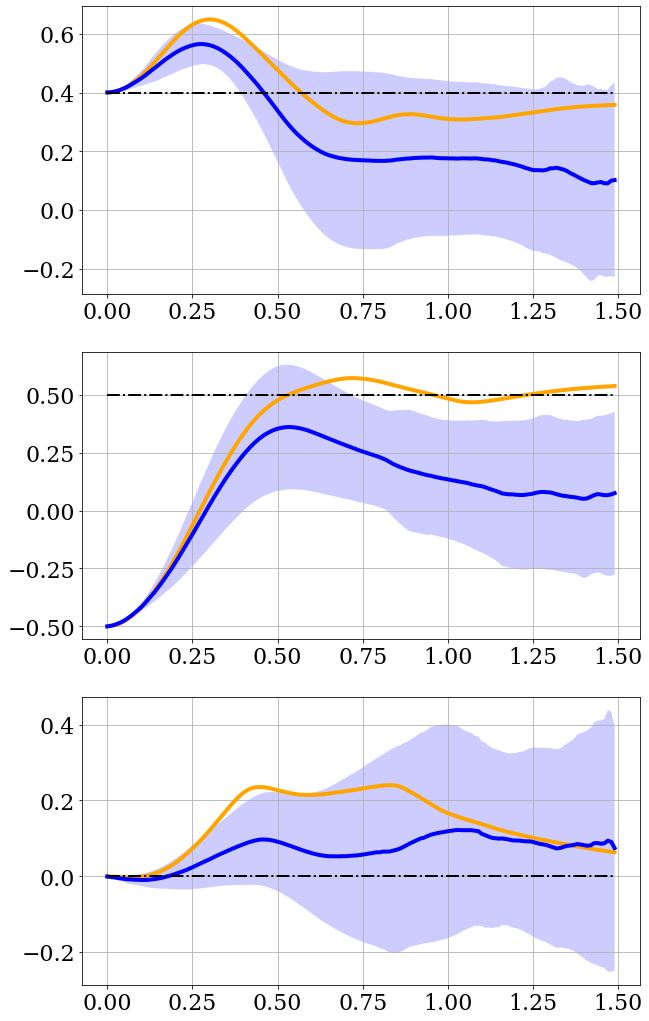

In [33]:
d = 3
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = ee_pred_mean_np - ee_pred_std_np
ub = ee_pred_mean_np + ee_pred_std_np

for i in range(d):
    ax[i].plot(t, ee_np[:, i], lw=4, color='orange', label='actual')
    ax[i].plot(t, ee_pred_mean_np[:, i], lw=4, color='b', label='predicted mean')
    ax[i].plot(t, goal[:, i], lw=2, color='k', ls='-.', label='goal')
    lb = ee_pred_mean_np - ee_pred_std_np
    ub = ee_pred_mean_np + ee_pred_std_np
    ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax[i].grid()
#     _ = ax[i].set_ylim([-3.2, 3.2])
#     ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
#              ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')

In [34]:
# traj_pred_mean = torch.mean(traj_pred, dim=1)
# traj_pred_std = torch.std(traj_pred, dim=1)

# traj_pred_mean_np = traj_pred_mean.detach().cpu().numpy()
# traj_pred_std_np = traj_pred_std.detach().cpu().numpy()
# traj_np = traj.detach().cpu().numpy()

# desired = task.cost.desired.repeat((task_horizon, 1))
# desired = desired.detach().cpu().numpy()

# d = nq
# dt = dt_control
# fig, ax = plt.subplots(d, figsize=(10, d * 6))
# t = np.arange(0.0, task_horizon*dt, dt)
# dlb = traj_pred_mean_np - traj_pred_std_np
# ub = traj_pred_mean_np + traj_pred_std_np

# for i in range(d):
#     ax[i].plot(t, traj_np[:, i], lw=4, color='orange', label='actual')
#     ax[i].plot(t, traj_pred_mean_np[:, i], lw=4, color='b', label='predicted mean')
#     ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
#     lb = traj_pred_mean_np - traj_pred_std_np
#     ub = traj_pred_mean_np + traj_pred_std_np
#     ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
#                 alpha=0.2)
#     _ = ax[i].grid()
# #     _ = ax[i].set_ylim([-3.2, 3.2])
# #     ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
# #              ncol=3, fancybox=True, shadow=True)
# # fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')